In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from imblearn.over_sampling import SMOTE
import pandas as pd 
from sklearn.impute import KNNImputer

In [2]:
def init_spark():
    spark = SparkSession.builder.appName("Python Spark SQL basic example").config("spark.some.config.option", "some-value").getOrCreate()
    return spark
spark_object = init_spark()

23/03/15 08:45:08 WARN Utils: Your hostname, karyubuntu resolves to a loopback address: 127.0.1.1; using 192.168.0.165 instead (on interface wlp0s20f3)
23/03/15 08:45:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/15 08:45:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/03/15 08:45:09 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Training data encoding and smote balancing 

In [3]:
train_spark = spark_object.read.option("delimiter", ",").csv("./data/traincleaned.csv", header='true', inferSchema='true')
train_spark = train_spark.drop(col("_c0"))
train_spark = train_spark.drop(col("id_31"))

In [4]:
train_pandas = train_spark.toPandas()

23/03/15 08:45:14 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
imputer = KNNImputer(n_neighbors=5)


In [6]:
cat_cols = [col for col in train_pandas.columns if train_pandas[col].dtype == 'object']

In [7]:
X_train_temp = pd.get_dummies(train_pandas.drop('isFraud', axis=1), columns=cat_cols)
y_train = train_pandas['isFraud']

X_train = pd.DataFrame(imputer.fit_transform(X_train_temp), columns=X_train_temp.columns)

In [8]:
sm = SMOTE(random_state=42)

In [9]:
X_sm, y_sm = sm.fit_resample(X_train, y_train)


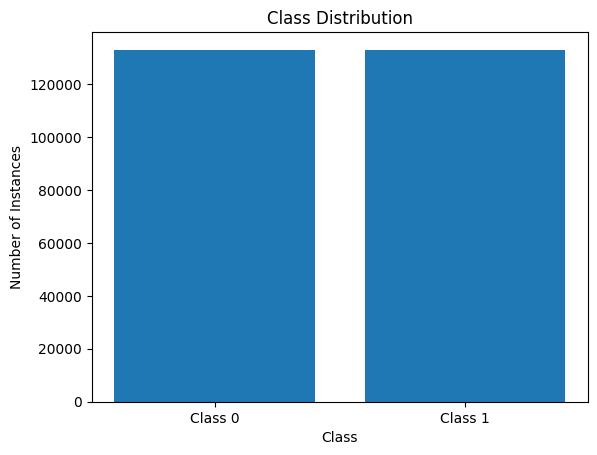

In [10]:
import matplotlib.pyplot as plt
import numpy as np

class_counts = np.bincount(y_sm)

plt.bar(range(len(class_counts)), class_counts)
plt.xticks(range(len(class_counts)), ['Class 0', 'Class 1'])
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution')
plt.show()


In [19]:
train_balanced_data = pd.concat([X_sm, y_sm], axis=1)
# print((train_balanced_data.count(), len(train_balanced_data.columns)))
train_balanced_data.to_csv('./data/trainbalanced.csv', index=False)

test data encoding 

In [11]:
test_spark = spark_object.read.option("delimiter", ",").csv("./data/testcleaned.csv", header='true', inferSchema='true')
test_spark = test_spark.drop(col("_c0"))
test_spark = test_spark.drop(col("id_31"))
print(len(test_spark.columns))

192


In [12]:
test_pandas = test_spark.toPandas()

In [13]:
dog_cols = [col for col in test_pandas.columns if test_pandas[col].dtype == 'object']

In [14]:
X_test = pd.get_dummies(test_pandas,columns=dog_cols)

In [18]:
# print((X_test.count(), len(X_test.columns)))
# print((train_balanced_data.count(), len(train_balanced_data.columns)))

(TransactionID         141907
TransactionDT         141907
TransactionAmt        141907
card1                 141907
card2                 139410
                       ...  
id_37_T               141907
id_38_F               141907
id_38_T               141907
DeviceType_desktop    141907
DeviceType_mobile     141907
Length: 210, dtype: int64, 210)
(TransactionID         265830
TransactionDT         265830
TransactionAmt        265830
card1                 265830
card2                 265830
                       ...  
id_38_F               265830
id_38_T               265830
DeviceType_desktop    265830
DeviceType_mobile     265830
isFraud               265830
Length: 211, dtype: int64, 211)


In [37]:
X_test.to_csv('./data/testbalanced.csv', index=False)